In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'PIL'

In [43]:
def label_img(name, folder):
    if folder!= 'pictures/data_vlad':
        word_label = list(name)[0]
    else:
        word_label = list(name)[-5]
    return word_label

In [2]:
IMG_SIZE = 28
import random
DIR = ['pictures/data_rus', 'pictures/data_yar', 'pictures/data_max', 'pictures/data_vlad']
def load_training_data():
    k=0
    train_data = []
    labels = []
    for folder in DIR:
        for img in os.listdir(str(folder)):
            label = label_img(img, folder)
            path = os.path.join(str(folder), img)
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            k+=1
            img.save('pictures/lol/niga'+str(k)+'.jpg')
            
            train_data.append(np.array(img))
            labels.append(label)
            # Basic Data Augmentation - Horizontal Flipping and Vertical Flipping
            flip_img = Image.open(path)
            flip_img = flip_img.convert('L')
            flip_img = flip_img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            flip_img1 = np.array(flip_img)
#             flip_img = np.flip(flip_img1,axis=1)
#             train_data.append(flip_img)
#             labels.append(label)
            flip_img = np.flip(flip_img1,axis=0)
            train_data.append(flip_img)
            labels.append(label)

    #     random.shuffle(train_data)
    train_data = np.array(train_data)
    return train_data, labels
data, labels = load_training_data()

NameError: name 'os' is not defined

In [160]:
def augment_images(data, labels, copies = 1, rotation=True, shear=True, shift=True, zoom=True):
    augmented_data = []
    augmented_labels = []
    
    for i in range (0, np.shape(labels)[0]):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        
        for j in range(1, copies):            
            img = data[i]
            lbl = labels[i]
                        
            if (rotation):
                img = tf.contrib.keras.preprocessing.image.random_rotation(img, 15, row_axis=0, col_axis=1, channel_axis=2)
            if (shear):
                img = tf.contrib.keras.preprocessing.image.random_shear(img, 0.1, row_axis=0, col_axis=1, channel_axis=2)
            if (shift):
                img = tf.contrib.keras.preprocessing.image.random_shift(img, 0.15, 0.15, row_axis=0, col_axis=1, channel_axis=2)
            if (zoom):
                img = tf.contrib.keras.preprocessing.image.random_zoom(img, (0.9, 1.1), row_axis=0, col_axis=1, channel_axis=2)
            
            augmented_data.append(img)
            augmented_labels.append(lbl)
    
    return np.array(augmented_data), np.array(augmented_labels)

In [161]:
X = data.reshape(-1, 28, 28, 1).astype(np.float32)
X /= 255.0
# X_test = test_data.values.reshape(-1, image_size, image_size, num_channels).astype(np.float32)


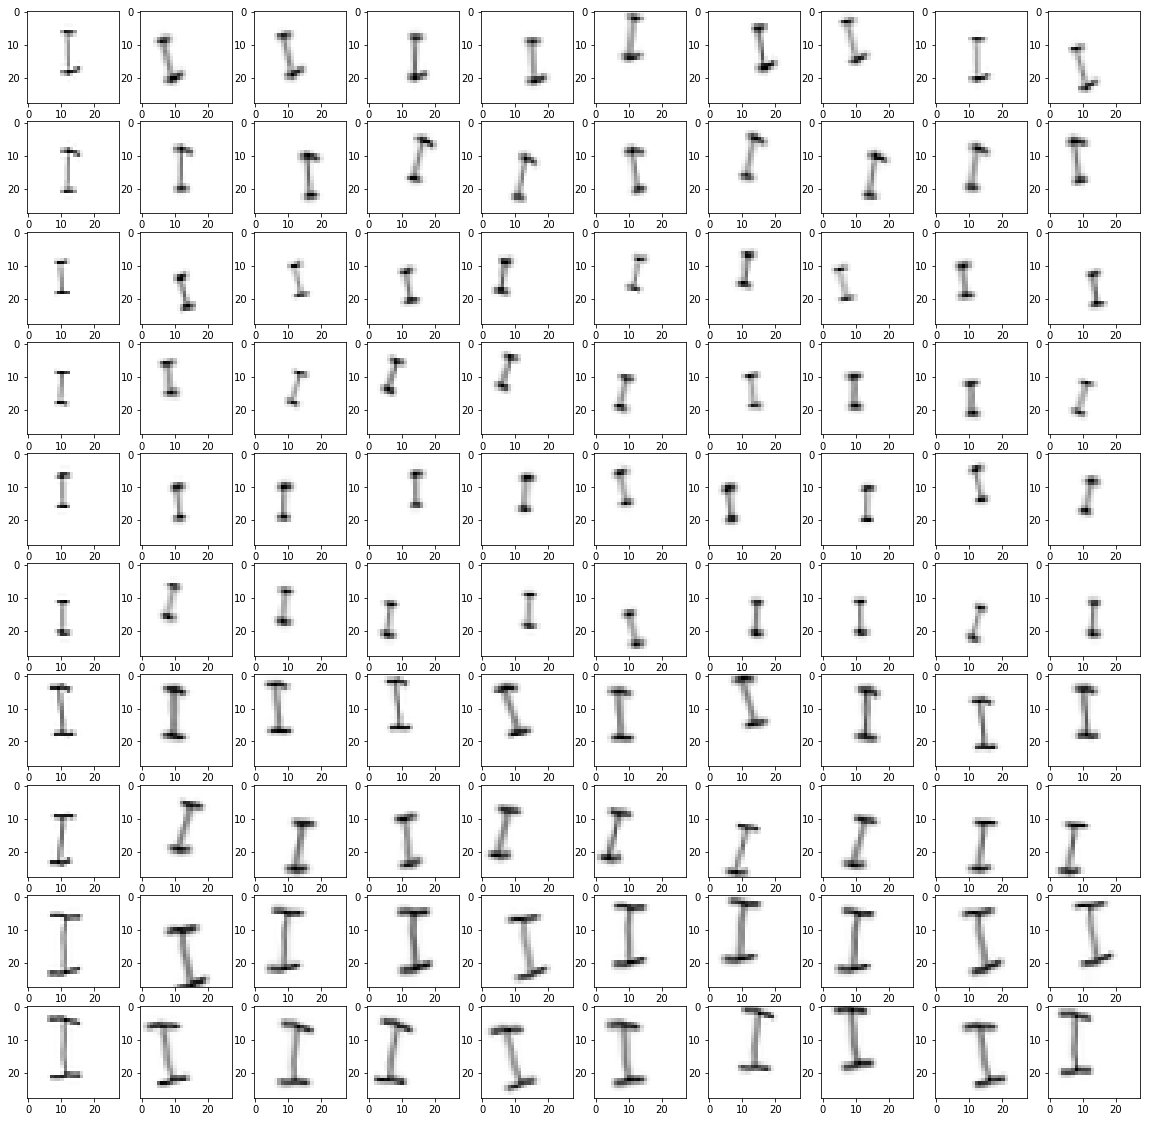

In [162]:
x = X[:10]
y = labels[:10]
x, y = augment_images(x, y, copies=10,zoom=False)

plt.figure(figsize=(20,20))
for i in range(len(x)):
    plt.subplot(10,10,1+i)
    plt.imshow(x[i].reshape(28,28), cmap='gist_gray')
    


In [163]:
data_, labels_ = augment_images(X, labels, copies=10,zoom=False)

In [212]:
data_.shape, labels_.shape

((7940, 28, 28, 1), (7940,))

In [225]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
labels_ = pd.get_dummies(labels_).values


In [226]:
print(len(data_),'==', len(labels_))

7940 == 7940


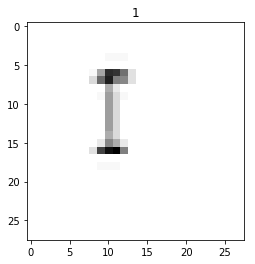

In [166]:
k=4
plt.title(labels[k])
plt.imshow(data[k], cmap = 'gist_gray')


In [167]:
from sklearn.model_selection import train_test_split

In [227]:
train_data,test_data,train_labels, test_labels = train_test_split(data_,labels_,test_size=0.2)

In [229]:
# train_labels = np.array(list(map(lambda x:int(x),train_labels)))
# test_labels = np.array(list(map(lambda x:int(x),test_labels)))

In [230]:
X_train, X_valid, Y_train, Y_valid = train_test_split(data_,labels_,test_size=0.2)
# Y_train = np.array(list(map(lambda x:int(x),Y_train)))
# Y_vlaid = np.array(list(map(lambda x:int(x),Y_valid)))

In [236]:
image_size = 28
num_channels = 1
num_labels = 8
graph = tf.Graph()
with graph.as_default():
    
    X = tf.placeholder(tf.float32, shape=(None,image_size,image_size,num_channels))
    Y_ = tf.placeholder(tf.float32, shape=(None,num_labels))
    tf_step = tf.placeholder(tf.float32)
    tf_pkeep = tf.placeholder(tf.float32)
    
    tf_test_dataset = tf.constant(X_valid)
    
    K = 6  # first convolutional layer output depth
    L = 12  # second convolutional layer output depth
    M = 24  # third convolutional layer output depth
    N = 200  # fully connected layer

    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    W5 = tf.Variable(tf.truncated_normal([N, 8], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [8]))
    
    def model(data):
        Y1 = tf.nn.relu(tf.nn.conv2d(data, W1, strides=[1, 1, 1, 1], padding='SAME') + B1) # output is 28x28
        Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME') + B2) # output is 14x14
        Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME') + B3)  # output is 7x7
        Y3_flat = tf.reshape(Y3, shape=[-1, 7 * 7 * M])
        Y4 = tf.nn.dropout(tf.nn.relu(tf.matmul(Y3_flat, W4) + B4), tf_pkeep)
        return tf.matmul(Y4, W5) + B5
    
    logits = model(X)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y_))*100
    
    lr = 0.0001 + tf.train.exponential_decay(0.005, tf_step, 2000, 1/math.e)
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss)   
    
    Y = tf.nn.softmax(logits)
    Y_test = tf.nn.softmax(model(tf_test_dataset))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1)), tf.float32))

In [ ]:
num_steps = 30001
batch_size = 100

acc = []
costs = []
rates = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (Y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = Y_train[offset:(offset + batch_size), :]
        
        if (step % 100 == 0):
            a, l, r = session.run([accuracy, loss, lr], feed_dict={
                X : batch_data, 
                Y_ : batch_labels,
                tf_pkeep : 1.0,
                tf_step : step
            })
            print(str(step) + ": accuracy: " + str(a) + " loss: " + str(l) + " (lr:" + str(r) + ")")
        
        if (step % 500 == 0):
            a, l = session.run([accuracy, loss], feed_dict={
                X : X_valid, 
                Y_ : Y_valid,
                tf_pkeep : 1.0
            })
            print(str(step) + ": validation accuracy: " + str(a) + " validation loss: " + str(l))        
        
        _, a, l, r = session.run([optimizer, accuracy, loss, lr], feed_dict={
            X : batch_data, 
            Y_: batch_labels,
            tf_pkeep : 0.75,
            tf_step : step
        })
        
        if (step % 10 == 0):
            costs.append(l)
            rates.append(r)
            acc.append(a)
            

0: accuracy: 0.09 loss: 237.63757 (lr:0.0050999997)
0: validation accuracy: 0.12972292 validation loss: 238.90233
100: accuracy: 0.06 loss: 208.73819 (lr:0.004856147)
200: accuracy: 0.15 loss: 207.79842 (lr:0.004624187)
300: accuracy: 0.16 loss: 208.1579 (lr:0.00440354)


In [211]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 150, 150, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=8)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [216]:
train_data = train_data/np.float32(255)

In [217]:
test_data = test_data/np.float32(255)

In [218]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="dataset")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'dataset', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000013784329CF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [219]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [220]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into dataset\model.ckpt.
INFO:tensorflow:probabilities = [[0.08526655 0.10135385 0.09941622 0.11201698 0.08136516 0.09435701
  0.09745558 0.09124628 0.1111957  0.12632658]
 [0.09647483 0.10291225 0.10550485 0.0981292  0.08459903 0.08427482
  0.09545761 0.1084789  0.10734597 0.11682257]
 [0.0832095  0.09292895 0.08965291 0.1005252  0.08360462 0.10969655
  0.10569964 0.0926978  0.11180252 0.13018234]
 [0.08078454 0.08311411 0.08653757 0.09818519 0.08410332 0.10458131
  0.11178196 0.09364876 0.12779696 0.12946633]
 [0.07406542 0.11670486 0.09724385 0.09330761 0.0866298  0.1030398
  0.10105841 0.09524287 0.12699899 0.10570833]
 [0.07857709 0.10118433 0.10367776 0.09810138 0.08171866 0.10735726
  0.08638439 0.10577937

INFO:tensorflow:loss = 2.2949426, step = 1
INFO:tensorflow:Saving checkpoints for 1 into dataset\model.ckpt.
INFO:tensorflow:Loss for final step: 2.2949426.


In [221]:
mnist_classifier.train(input_fn=train_input_fn, steps=1000)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from dataset\model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into dataset\model.ckpt.
INFO:tensorflow:loss = 2.325781, step = 2
INFO:tensorflow:global_step/sec: 0.43909
INFO:tensorflow:loss = 2.2247996, step = 102 (227.868 sec)
INFO:tensorflow:global_step/sec: 0.440976
INFO:tensorflow:loss = 2.1563408, step = 202 (226.753 sec)
INFO:tensorflow:Saving checkpoints for 265 into dataset\model.ckpt.
INFO:tensorflow:global_step/sec: 0.43612
INFO:tensorflow:loss = 2.1363306, step = 302 (229.189 sec)
INFO:tensorflow:global_step/sec: 0.441225
INFO:tensorflow:loss = 2.1250036, step = 402 (226.751 sec)
INFO:tensorflow:global_step/sec: 0.440728
INFO:tensorflow:loss = 2.103356, step = 502 (226.899 sec)
INFO:tensorflow:Saving

In [223]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.


TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64

In [86]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

# (x_train, y_train),(x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
train_data, test_data = train_data/255.0, test_data/255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(150, 150)),
  tf.keras.layers.Dense(2048, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(input_shape=(32, 32)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
 
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.fit(train_data, train_labels, epochs=20)
# model.evaluate(test_data, test_labels)

In [87]:
model.fit(train_data, train_labels, epochs=20)

Epoch 1/20
192/594 [========>.....................] - ETA: 18s - loss: 2.2963 - acc: 0.1406

KeyboardInterrupt: 

In [90]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [95]:
set(train_labels)

{1, 2, 3, 4, 5, 6, 7, 8, 9}